In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# ARIMA model and autocorrelation plots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

This cell constructs a Series called y that contains the target feature - in this case, hourly electricity demand.

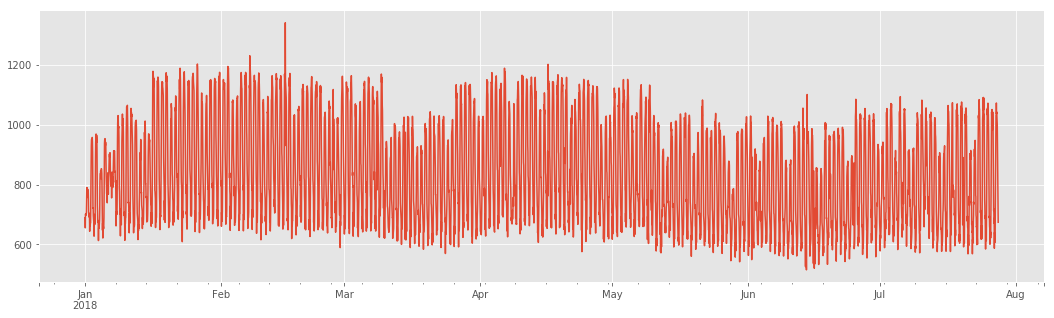

In [4]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

# sum the remaining buildings
y = pd.Series(elec.iloc[:, 0:11].sum(axis=1))

y.plot(figsize=(18,5))

### Autocorrelation plots

The plots below show the autocorrelation and partial autocorrelation of the raw demand data. The shaded red cone shows the 95% confidence interval, meaning all dots outside of the cone are statistically significant. The dots themselves represent lag features, where the first dot is lag by one hour, and the second by two hours. See how the 24th and 48th lag features have a strong positive correlation.

Following the Box-Jenkins methodology, these plots can be used to inform the type of ARIMA model to be used.
https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method

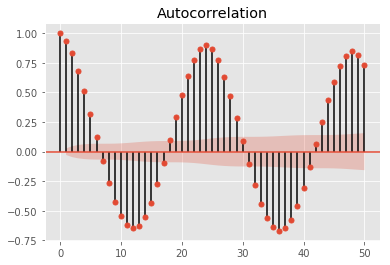

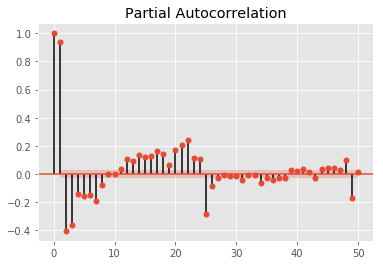

In [3]:
plot_acf(y, lags=50)
plt.show()
plot_pacf(y, lags=50)
plt.show()

### ARIMA forecasting

The cell below includes some helper functions that are used in the ARIMA model.

TO DO: Implement a grid search to identify the best (p,d,q) ARIMA parameters

In [6]:
# helper functions for ARIMA forecasting

def difference(dataset, interval=1):
    """Returns the difference over a specific interval"""
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    """Inverts a series that has been differenced"""
    return yhat + history[-interval]


In [5]:
# construct empty dataframe to populate with results
mapes = pd.DataFrame(columns=['hours_trained','mape'])

# define split times and end times to cut X and y into training and testing sets
split_times = pd.date_range(start='2018-02-10 08:00:00',freq='D',periods=100)
end_times = split_times.shift(39,freq='H')

# loop to run models and add hours_trained & mape data to the mapes dataframe
for i in range(len(split_times)):
    
    # define training and testing sets based on split_times and end_times
    y_train = y.loc[y.index <= split_times[i]].copy().values
    y_test = y.loc[(y.index > split_times[i]) & (y.index <= end_times[i])].copy()
      
    # calculate the 24-hour difference on the training data
    differenced = difference(y_train, 24)

    # fit the model to the differenced data
    model = ARIMA(differenced, order=(7,0,1))
    model_fit = model.fit(disp=0)

    # multi-step out-of-sample forecast
    forecast = model_fit.forecast(steps=39)[0]

    # invert the differenced forecast and store results
    history = [i for i in y_train]
    for yhat in forecast:
        inverted = inverse_difference(history, yhat, 24)
        history.append(inverted)
        
    y_pred = history[len(history)-39:]
    
    # store the results of the model and append the mapes dataframe
    hours_trained = len(y_train)
    mape = np.mean(np.abs((y_test - y_pred) / y_test))*100
    mapes = mapes.append({'hours_trained':hours_trained,'mape':mape},ignore_index=True)

print('The average MAPE for {} test days was {}'.format(len(mapes),np.round(np.mean(mapes['mape']),2)))

The average MAPE over a 100 day test period was 6.76


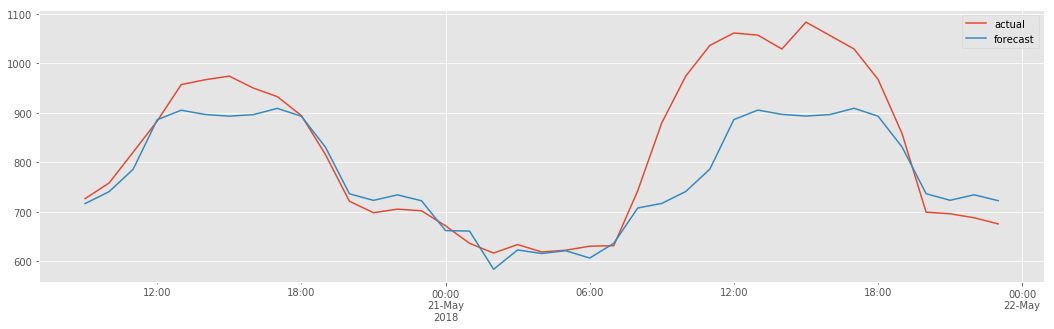

In [6]:
latest_forecast = pd.DataFrame(y_test,columns=['actual'])
latest_forecast['forecast'] = y_pred

latest_forecast.plot(figsize=(18,5))

### SARIMA Modeling - Encoding a seasonal element

The SARIMA (seasonal autoregressive integrated moving average) model introduces four new parameters: P,D,Q, and m. P,D, and Q are the *seasonal* autoregressive, differencing, and moving average terms, while m is the period. For the demand data, m should be 24.

Here I removed the 24 hour differencing that was necessary in the ARIMA model.

In [32]:
# construct empty dataframe to populate with results
mapes = pd.DataFrame(columns=['hours_trained','mape'])
y_predicted = y.copy(deep=True)

# define split times and end times to cut X and y into training and testing sets
split_times = pd.date_range(start='2018-02-10 08:00:00',freq='D',periods=10)
end_times = split_times.shift(39,freq='H')

# loop to run models and add hours_trained & mape data to the mapes dataframe
for i in range(len(split_times)):
    
    # define training and testing sets based on split_times and end_times
    y_train = y.loc[y.index <= split_times[i]].copy().values
    y_test = y.loc[(y.index > split_times[i]) & (y.index <= end_times[i])].copy()

    # fit the model to the differenced data
    model = SARIMAX(y_train, order=(0,0,0),seasonal_order=(1,0,1,24),enforce_stationarity=False)
    model_fit = model.fit(disp=0,maxiter=200)

    # multi-step out-of-sample forecast
    forecast = model_fit.forecast(steps=39)
    y_pred = forecast
    y_predicted.loc[(y.index > split_times[i]) & (y.index <= end_times[i])] = y_pred
    
    # store the results of the model and append the mapes dataframe
    hours_trained = len(y_train)
    mape = np.mean(np.abs((y_test[15:] - y_pred[15:]) / y_test[15:]))*100
    mapes = mapes.append({'hours_trained':hours_trained,'mape':mape},ignore_index=True)

print('The average MAPE for {} test days was {}'.format(len(mapes),np.round(np.mean(mapes['mape']),2)))

The average MAPE over a 10 day test period was 5.72


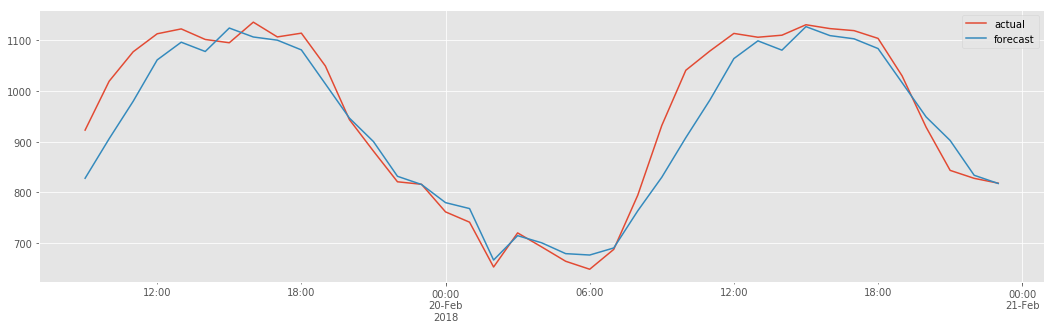

In [33]:
# plot the latest forecast
latest_forecast = pd.DataFrame(y_test,columns=['actual'])
latest_forecast['forecast'] = y_pred
latest_forecast.plot(figsize=(18,5))